In [40]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("/kaggle/input/preguntasquora/preguntas.csv")

MAX_VOCAB_SIZE = 20000 
MAX_SEQUENCE_LENGTH = 50 

vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_VOCAB_SIZE, output_sequence_length=MAX_SEQUENCE_LENGTH)
vectorizer.adapt(df['question1'].tolist() + df['question2'].tolist())

q1_seq = vectorizer(df['question1'].tolist()).numpy()
q2_seq = vectorizer(df['question2'].tolist()).numpy()

y = df['is_duplicate'].values
q1_train, q1_test, q2_train, q2_test, y_train, y_test = train_test_split(q1_seq, q2_seq, y, test_size=0.2, random_state=42)

EMBEDDING_DIM = 100

In [3]:
model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [4]:
history = model.fit([q1_train, q2_train], y_train, batch_size=128, epochs=10, validation_data=([q1_test, q2_test], y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.6541 - loss: 0.6308 - val_accuracy: 0.7319 - val_loss: 0.5364
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7528 - loss: 0.5079 - val_accuracy: 0.7468 - val_loss: 0.5128
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7749 - loss: 0.4691 - val_accuracy: 0.7505 - val_loss: 0.5147
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7939 - loss: 0.4344 - val_accuracy: 0.7473 - val_loss: 0.5167
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8120 - loss: 0.4045 - val_accuracy: 0.7485 - val_loss: 0.5341
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8294 - loss: 0.3726 - val_accuracy: 0.7474 - val_loss: 0.5400
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8460 - loss: 0.3409 - val_accuracy: 0.7538 - val_loss: 0.5950
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8602 - loss: 0

In [10]:
def plotLossAccuracy(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Evolución de la pérdida')
    plt.ylim(bottom=0)
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Evolución de la precisión')
    plt.ylim(bottom=0)
    
    plt.show()

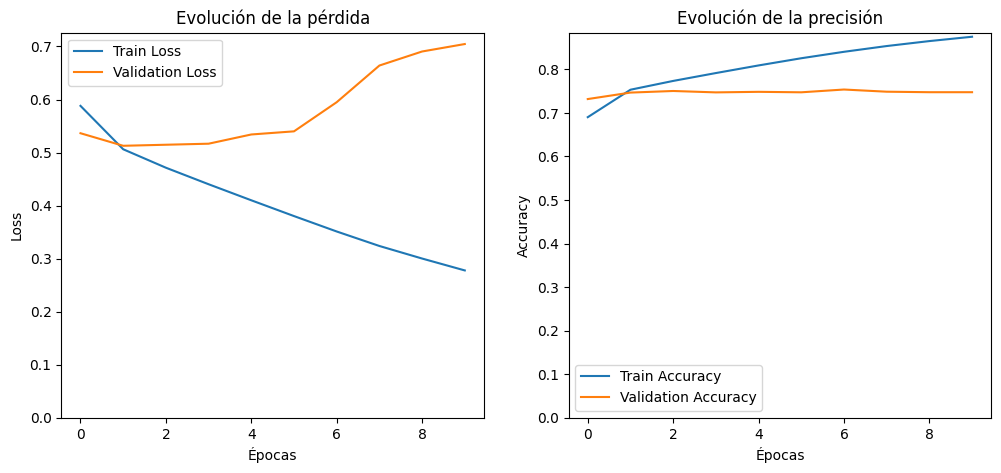

In [11]:
plotLossAccuracy(history)

In [13]:
def evaluateModel(model):
    y_pred = (model.predict([q1_test, q2_test]) > 0.5).astype(int)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Duplicada', 'Duplicada'], yticklabels=['No Duplicada', 'Duplicada'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de confusión')
    plt.show()
    
    print("Informe de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['No Duplicada', 'Duplicada']))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


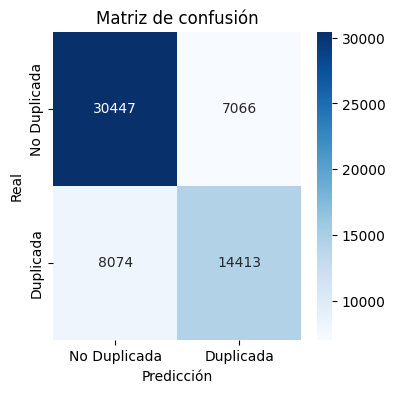

Informe de clasificación:
              precision    recall  f1-score   support

No Duplicada       0.79      0.81      0.80     37513
   Duplicada       0.67      0.64      0.66     22487

    accuracy                           0.75     60000
   macro avg       0.73      0.73      0.73     60000
weighted avg       0.75      0.75      0.75     60000



In [14]:
evaluateModel(model)

In [7]:
model2 = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model2.fit([q1_train, q2_train], y_train, batch_size=128, epochs=20, validation_data=([q1_test, q2_test], y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.6756 - loss: 0.6045 - val_accuracy: 0.7361 - val_loss: 0.5244
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7558 - loss: 0.5038 - val_accuracy: 0.7484 - val_loss: 0.5136
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7728 - loss: 0.4693 - val_accuracy: 0.7513 - val_loss: 0.5111
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7913 - loss: 0.4362 - val_accuracy: 0.7511 - val_loss: 0.5306
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8108 - loss: 0.4049 - val_accuracy: 0.7544 - val_loss: 0.5445
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8305 - loss: 0.3703 - val_accuracy: 0.7421 - val_loss: 0.5774
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8440 - loss: 0.3436 - val_accuracy: 0.7508 - val_loss: 0.6156
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8563 - loss: 0

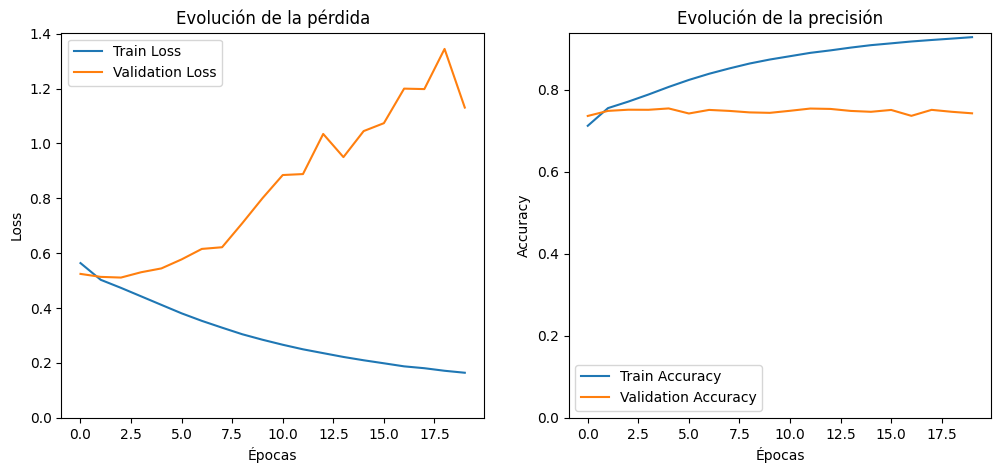

In [12]:
plotLossAccuracy(history2)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


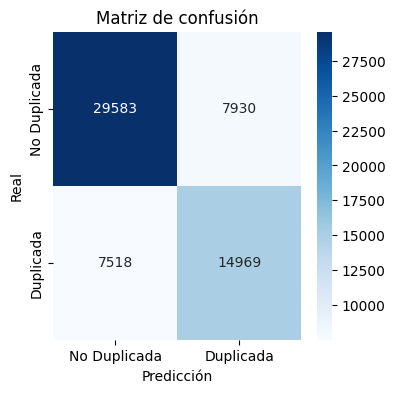

Informe de clasificación:
              precision    recall  f1-score   support

No Duplicada       0.80      0.79      0.79     37513
   Duplicada       0.65      0.67      0.66     22487

    accuracy                           0.74     60000
   macro avg       0.73      0.73      0.73     60000
weighted avg       0.74      0.74      0.74     60000



In [15]:
evaluateModel(model2)

In [37]:
model3 = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,)),
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(32, return_sequences=True, dropout=0.3)),
    Bidirectional(LSTM(16, dropout=0.3)),    
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,verbose=1)

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history3 = model3.fit([q1_train, q2_train], y_train, batch_size=128, epochs=20, validation_data=([q1_test, q2_test], y_test),callbacks=[early_stop, reduce_lr])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.7071 - loss: 0.5687 - val_accuracy: 0.7431 - val_loss: 0.5174 - learning_rate: 0.0010
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.7634 - loss: 0.4898 - val_accuracy: 0.7456 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.7806 - loss: 0.4549 - val_accuracy: 0.7480 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 4/20
1872/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7932 - loss: 0.4314
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.7932 - loss: 0.4314 - val_accuracy: 0.7498 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.8111 - loss: 0.3974 - val_accuracy: 0.7474 - val_loss: 0.5470 - learning_rate: 5.0000e-04
Epoch 6/20
1871/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accur

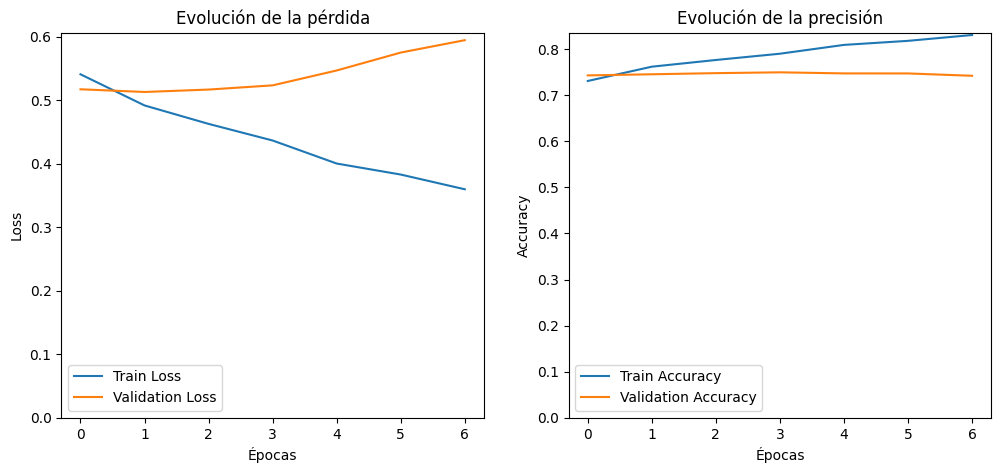

In [38]:
plotLossAccuracy(history3)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


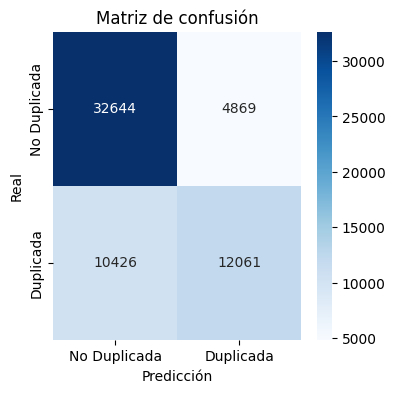

Informe de clasificación:
              precision    recall  f1-score   support

No Duplicada       0.76      0.87      0.81     37513
   Duplicada       0.71      0.54      0.61     22487

    accuracy                           0.75     60000
   macro avg       0.74      0.70      0.71     60000
weighted avg       0.74      0.75      0.74     60000



In [39]:
evaluateModel(model3)